In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import numpy as np
from pyuvdata import UVCal, UVData
import os
import sys
import glob
import uvtools as uvt
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, Angle
from astropy.coordinates import SkyCoord as sc
import pandas
import warnings 
import copy
from hera_notebook_templates import utils
import hera_qm
from hera_mc import cm_hookup
import h5py
import importlib
from scipy import stats
from IPython.display import display, HTML
from scipy.signal import find_peaks
#warnings.filterwarnings('ignore')

from scipy import signal
from numpy.fft import ifft
from numpy.random import default_rng

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
display(HTML("<style>.container { width:100% !important; }</style>"))

could not import sklearn


In [2]:
#get data location
JD = 2460055
data_path = '/lustre/aoc/projects/hera/nmohamed/demo/2460055'
ant_metrics_ext = ".known_good.ant_metrics.hdf5"
statuses = 'RF_ok,digital_ok,digital_maintenance,calibration_ok,RF_maintenance'
utc = Time(JD, format='jd').datetime
print(f'JD = {JD}')
print(f'Date = {utc.month}-{utc.day}-{utc.year}')
print(f'data_path = "{data_path}"')

JD = 2460055
Date = 4-20-2023
data_path = "/lustre/aoc/projects/hera/nmohamed/demo/2460055"


In [3]:
# Load in data

HHautos = glob.glob('/lustre/aoc/projects/hera/nmohamed/demo/2460055/*.uvh5')
#HHfiles, difffiles, HHautos, diffautos, uvdx, uvdy = utils.load_data(data_path,JD)
    
uvd = UVData()
unread = True
readInd=0
while unread and readInd<len(HHautos):
    try:
        uvd.read(HHautos[readInd])
        unread = False
    except:
        readInd += 1
        continue
#use_ants = utils.get_use_ants(uvd,statuses,JD)
#print(f'This day contains {len(use_ants)} antennas of the given status category.')
uvd.read(HHautos, skip_bad_files=False)
lsts = uvd.lst_array
# uvdx.select(antenna_nums=use_ants)
# uvdy.select(antenna_nums=use_ants)

In [4]:
HHautos

['/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.49184.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.44732.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.46544.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.49251.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.46410.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.49788.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.44978.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.50012.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.46947.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.44039.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.50168.sum.autos.uvh5',
 '/lustre/aoc/projects/hera/nmohamed/demo/2460055/zen.2460055.472

In [35]:
np.unique(uvd.ant_1_array)

array([None], dtype=object)

In [5]:
def plot_four_clocks (ant1, ant2, ant3, ant4):
    fig, ax = plt.subplots(2 , 2, figsize = (15,12))

    data1 = uvd.get_data(ant1,ant1,'XX')
    data2 = uvd.get_data(ant1,ant1,'YY')
    freq = uvd.freq_array[0]*1e-6 #converted to MegaHz

    clocks1, _ = find_peaks(np.average(data1, axis=0), distance=400)
    clocks2, _ = find_peaks(np.average(data2, axis=0), distance=400)
    ax[0,0].plot(freq,np.average(data1, axis=0))
    ax[0,0].plot(freq[clocks1],np.average(data1, axis=0)[clocks1],"xr")
    ax[0,0].plot(freq,np.average(data2, axis=0))
    ax[0,0].plot(freq[clocks2],np.average(data2, axis=0)[clocks2],"xr")
    ax[0,0].set_yscale('log')
    ax[0,0].set_xlabel(f'Frequency (MHz) of antenna {ant1}')

    data3 = uvd.get_data(ant2,ant2,'XX')
    data4 = uvd.get_data(ant2,ant2,'YY')
    freq = uvd.freq_array[0]*1e-6 #converted to MegaHz

    clocks3, _ = find_peaks(np.average(data3, axis=0), distance=400)
    clocks4, _ = find_peaks(np.average(data4, axis=0), distance=400)
    ax[0,1].plot(freq,np.average(data3, axis=0))
    ax[0,1].plot(freq[clocks3],np.average(data3, axis=0)[clocks3],"xr")
    ax[0,1].plot(freq,np.average(data4, axis=0))
    ax[0,1].plot(freq[clocks4],np.average(data4, axis=0)[clocks4],"xr")
    ax[0,1].set_yscale('log')
    ax[0,1].set_xlabel(f'Frequency (MHz) of antenna {ant2}')

    data5 = uvd.get_data(ant3,ant3,'XX')
    data6 = uvd.get_data(ant3,ant3,'YY')
    freq = uvd.freq_array[0]*1e-6 #converted to MegaHz

    clocks5, _ = find_peaks(np.average(data5, axis=0), distance=400)
    clocks6, _ = find_peaks(np.average(data6, axis=0), distance=400)
    ax[1,0].plot(freq,np.average(data5, axis=0))
    ax[1,0].plot(freq[clocks5],np.average(data5, axis=0)[clocks5],"xr")
    ax[1,0].plot(freq,np.average(data6, axis=0))
    ax[1,0].plot(freq[clocks6],np.average(data6, axis=0)[clocks6],"xr")
    ax[1,0].set_yscale('log')
    ax[1,0].set_xlabel(f'Frequency (MHz) of antenna {ant3}')

    data7 = uvd.get_data(ant4,ant4,'XX')
    data8 = uvd.get_data(ant4,ant4,'YY')
    freq = uvd.freq_array[0]*1e-6 #converted to MegaHz

    clocks7, _ = find_peaks(np.average(data7, axis=0), distance=400)
    clocks8, _ = find_peaks(np.average(data8, axis=0), distance=400)
    fig = plt.figure(figsize=(12,12))
    ax[1,1].plot(freq,np.average(data7, axis=0))
    ax[1,1].plot(freq[clocks7],np.average(data7, axis=0)[clocks7],"xr")
    ax[1,1].plot(freq,np.average(data8, axis=0))
    ax[1,1].plot(freq[clocks8],np.average(data8, axis=0)[clocks8],"xr")
    ax[1,1].set_yscale('log')
    ax[1,1].set_xlabel(f'Frequency (MHz) of antenna {ant4}')

    #fig = plt.figure(figsize=(12,12))
    #plt.plot(freq,data1[187,:])
    #plt.plot(freq,data2[187,:])
    #plt.yscale('log')
    #plt.xlabel('Frequency (MHz)')
    #print (len(freq))
    print (freq[128], freq[640], freq[1152])
    print (freq[128], freq[640], freq[1152])

In [19]:
def plot_four_noclocks_even (ant1, ant2, ant3, ant4, start, space, num):
    #print(clocks1)
    # print((-np.average(data1, axis=0)).argsort()[:3])
    fig, ax = plt.subplots(2 , 2, figsize = (15,12))
    
    #ax = axes[0, 0]
    
    data1 = uvd.get_data(ant1,ant1,'XX')
    data2 = uvd.get_data(ant1,ant1,'YY')
    data3 = uvd.get_data(ant2,ant2,'XX')
    data4 = uvd.get_data(ant2,ant2,'YY')
    data5 = uvd.get_data(ant3,ant3,'XX')
    data6 = uvd.get_data(ant3,ant3,'YY')
    data7 = uvd.get_data(ant4,ant4,'XX')
    data8 = uvd.get_data(ant4,ant4,'YY')
    freq = uvd.freq_array[0]*1e-6 #converted to MegaHz

    data1_avg = np.average(data1, axis=0)
    data1_avg[128] = (data1_avg[127] + data1_avg[129])/2
    data1_avg[1152] = (data1_avg[1151] + data1_avg[1153])/2
    data1_avg[640] = (data1_avg[639] + data1_avg[641])/2
    data2_avg = np.average(data2, axis=0)
    data2_avg[128] = (data2_avg[127] + data2_avg[129])/2
    data2_avg[1152] = (data2_avg[1151] + data2_avg[1153])/2
    data2_avg[640] = (data2_avg[639] + data2_avg[641])/2
    peaks1, _ = find_peaks(data1_avg[0:768], distance=40)
    peaks2, _ = find_peaks(data2_avg[0:768], distance=40)
    ax[0,0].plot(freq[0:768],data1_avg[0:768], label = 'XX')
    #ax[0,0].plot(freq[peaks1],data1_avg[peaks1],"xr")
    ax[0,0].plot(freq[0:768],data2_avg[0:768], label = 'YY')
    #ax[0,0].plot(freq[peaks2],data2_avg[peaks2],"xr")
    ax[0,0].legend()
    
    axmin, axmax = ax[0,0].get_ylim()
    
    lines = np.arange(0,num,1)
    number = 0
        
    for i in lines:
        ax[0,0].vlines(start+space*number, ymin = 0, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)
        number = (number + 1)
        
    ax[0,0].set_title(f'Antenna {ant1}')
    ax[0,0].set_yscale('log')
    ax[0,0].set_xlabel(f'Frequency (MHz)')


    data3_avg = np.average(data3, axis=0)
    data3_avg[128] = (data3_avg[127] + data3_avg[129])/2
    data3_avg[1152] = (data3_avg[1151] + data3_avg[1153])/2
    data3_avg[640] = (data3_avg[639] + data3_avg[641])/2
    data4_avg = np.average(data4, axis=0)
    data4_avg[128] = (data4_avg[127] + data4_avg[129])/2
    data4_avg[1152] = (data4_avg[1151] + data4_avg[1153])/2
    data4_avg[640] = (data4_avg[639] + data4_avg[641])/2
    peaks3, _ = find_peaks(data3_avg[0:768], distance=40)
    peaks4, _ = find_peaks(data4_avg[0:768], distance=40)
    fig = plt.figure(figsize=(12,12))
    ax[0,1].plot(freq[0:768],data3_avg[0:768], label = 'XX')
    #ax[0,1].plot(freq[peaks3],data3_avg[peaks3],"xr")
    ax[0,1].plot(freq[0:768],data4_avg[0:768], label = 'YY')
    #ax[0,1].plot(freq[peaks4],data4_avg[peaks4],"xr")
    ax[0,1].legend()
    
    axmin, axmax = ax[0,1].get_ylim()
    number = 0
    
    for i in lines:
        ax[0,1].vlines(start+space*number, ymin = 0, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)
        number = (number + 1)

    ax[0,1].set_title(f'Antenna {ant2}')
    ax[0,1].set_yscale('log')
    ax[0,1].set_xlabel(f'Frequency (MHz)')

    data5_avg = np.average(data5, axis=0)
    data5_avg[128] = (data5_avg[127] + data5_avg[129])/2
    data5_avg[1152] = (data5_avg[1151] + data5_avg[1153])/2
    data5_avg[640] = (data5_avg[639] + data5_avg[641])/2
    data6_avg = np.average(data6, axis=0)
    data6_avg[128] = (data6_avg[127] + data6_avg[129])/2
    data6_avg[1152] = (data6_avg[1151] + data6_avg[1153])/2
    data6_avg[640] = (data6_avg[639] + data6_avg[641])/2
    peaks5, _ = find_peaks(data5_avg[0:768], distance=40)
    peaks6, _ = find_peaks(data6_avg[0:768], distance=40)
    fig = plt.figure(figsize=(12,12))
    ax[1,0].plot(freq[0:768],data5_avg[0:768], label = 'XX')
    #ax[1,0].plot(freq[peaks5],data5_avg[peaks5],"xr")
    ax[1,0].plot(freq[0:768],data6_avg[0:768], label = 'YY')
    #ax[1,0].plot(freq[peaks6],data6_avg[peaks6],"xr")
    ax[1,0].legend()
    
    axmin, axmax = ax[1,0].get_ylim()
    number = 0
    
    for i in lines:
        ax[1,0].vlines(start+space*number, ymin = 0, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)
        number = (number + 1)

    ax[1,0].set_title(f'Antenna {ant3}')
    ax[1,0].set_yscale('log')
    ax[1,0].set_xlabel(f'Frequency (MHz)')

    data7_avg = np.average(data7, axis=0)
    data7_avg[128] = (data7_avg[127] + data7_avg[129])/2
    data7_avg[1152] = (data7_avg[1151] + data7_avg[1153])/2
    data7_avg[640] = (data7_avg[639] + data7_avg[641])/2
    data8_avg = np.average(data8, axis=0)
    data8_avg[128] = (data8_avg[127] + data8_avg[129])/2
    data8_avg[1152] = (data8_avg[1151] + data8_avg[1153])/2
    data8_avg[640] = (data8_avg[639] + data8_avg[641])/2
    peaks7, _ = find_peaks(data7_avg[0:768], distance=40)
    peaks8, _ = find_peaks(data8_avg[0:768], distance=40)
    fig = plt.figure(figsize=(12,12))
    ax[1,1].plot(freq[0:768],data7_avg[0:768], label = 'XX')
    #ax[1,1].plot(freq[peaks7],data7_avg[peaks7],"xr")
    ax[1,1].plot(freq[0:768],data8_avg[0:768], label = 'YY')
    #ax[1,1].plot(freq[peaks8],data8_avg[peaks8],"xr")
    ax[1,1].legend()
    
    axmin, axmax = ax[1,1].get_ylim()
    number = 0
    
    for i in lines:
        ax[1,1].vlines(start+space*number, ymin = 0, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)
        number = (number + 1)

    ax[1,1].set_title(f'Antenna {ant4}')
    ax[1,1].set_yscale('log')
    ax[1,1].set_xlabel(f'Frequency (MHz)')

    print(freq[peaks1[0:11]])
    print(freq[peaks2[0:11]])
    
    print (f'Antenna{ant1} xx and yy')
    print(freq[peaks1[0:11]])
    print(freq[peaks2[0:11]])
    print (f'Antenna{ant2} xx and yy')
    print(freq[peaks3[0:11]])
    print(freq[peaks4[0:11]])
    print (f'Antenna{ant3} xx and yy')
    print(freq[peaks5[0:11]])
    print(freq[peaks6[0:11]])
    print (f'Antenna{ant4} xx and yy')
    print(freq[peaks7[0:11]])
    print(freq[peaks8[0:11]])

In [16]:
def plot_four_noclocks_even_yy (ant1, ant2, ant3, ant4, start, space, num):
    #print(clocks1)
    # print((-np.average(data1, axis=0)).argsort()[:3])
    fig, ax = plt.subplots(2 , 2, figsize = (15,12))
    
    #ax = axes[0, 0]
    
    data1 = uvd.get_data(ant1,ant1,'XX')
    data2 = uvd.get_data(ant1,ant1,'YY')
    data3 = uvd.get_data(ant2,ant2,'XX')
    data4 = uvd.get_data(ant2,ant2,'YY')
    data5 = uvd.get_data(ant3,ant3,'XX')
    data6 = uvd.get_data(ant3,ant3,'YY')
    data7 = uvd.get_data(ant4,ant4,'XX')
    data8 = uvd.get_data(ant4,ant4,'YY')
    freq = uvd.freq_array[0]*1e-6 #converted to MegaHz

    data1_avg = np.average(data1, axis=0)
    data1_avg[128] = (data1_avg[127] + data1_avg[129])/2
    data1_avg[1152] = (data1_avg[1151] + data1_avg[1153])/2
    data1_avg[640] = (data1_avg[639] + data1_avg[641])/2
    data2_avg = np.average(data2, axis=0)
    data2_avg[128] = (data2_avg[127] + data2_avg[129])/2
    data2_avg[1152] = (data2_avg[1151] + data2_avg[1153])/2
    data2_avg[640] = (data2_avg[639] + data2_avg[641])/2
    peaks1, _ = find_peaks(data1_avg[0:768], distance=40)
    peaks2, _ = find_peaks(data2_avg[0:768], distance=40)
    ax[0,0].plot(freq[0:768],data1_avg[0:768], label = f'XX: first peak {freq[peaks1[0]]:.3f}')
    ax[0,0].plot(freq[peaks1],data1_avg[peaks1],"xr")
    ax[0,0].plot(freq[0:768],data2_avg[0:768], label = f'YY: first peak {freq[peaks2[0]]:.3f}')
    ax[0,0].plot(freq[peaks2],data2_avg[peaks2],"xr")
    ax[0,0].legend()
    
    axmin, axmax = ax[0,0].get_ylim()
    
    lines = np.arange(0,num,1)
    number = 0
        
    for i in lines:
        ax[0,0].vlines(start+space*number, ymin = 0, ymax = axmax, color = 'k', ls = '--')
        number = (number + 1)
        
    ax[0,0].set_yscale('log')
    ax[0,0].set_xlabel(f'Frequency (MHz) of antenna {ant1}')


    data3_avg = np.average(data3, axis=0)
    data3_avg[128] = (data3_avg[127] + data3_avg[129])/2
    data3_avg[1152] = (data3_avg[1151] + data3_avg[1153])/2
    data3_avg[640] = (data3_avg[639] + data3_avg[641])/2
    data4_avg = np.average(data4, axis=0)
    data4_avg[128] = (data4_avg[127] + data4_avg[129])/2
    data4_avg[1152] = (data4_avg[1151] + data4_avg[1153])/2
    data4_avg[640] = (data4_avg[639] + data4_avg[641])/2
    peaks3, _ = find_peaks(data3_avg[0:768], distance=40)
    peaks4, _ = find_peaks(data4_avg[0:768], distance=40)
    fig = plt.figure(figsize=(12,12))
    ax[0,1].plot(freq[0:768],data3_avg[0:768], label = f'XX: first peak {freq[peaks3][0]:.3f}')
    ax[0,1].plot(freq[peaks3],data3_avg[peaks3],"xr")
    ax[0,1].plot(freq[0:768],data4_avg[0:768], label = f'YY: first peak {freq[peaks4][0]:.3f}')
    ax[0,1].plot(freq[peaks4],data4_avg[peaks4],"xr")
    ax[0,1].legend()
    
    axmin, axmax = ax[0,1].get_ylim()
    number = 0
        
    for i in lines:
        ax[0,1].vlines(start+space*number, ymin = 0, ymax = axmax, color = 'k', ls = '--')
        number = (number + 1)
        
    ax[0,1].set_yscale('log')
    ax[0,1].set_xlabel(f'Frequency (MHz) of antenna {ant2}')

    data5_avg = np.average(data5, axis=0)
    data5_avg[128] = (data5_avg[127] + data5_avg[129])/2
    data5_avg[1152] = (data5_avg[1151] + data5_avg[1153])/2
    data5_avg[640] = (data5_avg[639] + data5_avg[641])/2
    data6_avg = np.average(data6, axis=0)
    data6_avg[128] = (data6_avg[127] + data6_avg[129])/2
    data6_avg[1152] = (data6_avg[1151] + data6_avg[1153])/2
    data6_avg[640] = (data6_avg[639] + data6_avg[641])/2
    peaks5, _ = find_peaks(data5_avg[0:768], distance=40)
    peaks6, _ = find_peaks(data6_avg[0:768], distance=40)
    fig = plt.figure(figsize=(12,12))
    ax[1,0].plot(freq[0:768],data5_avg[0:768], label = f'XX: first peak {freq[peaks5][0]:.3f}')
    ax[1,0].plot(freq[peaks5],data5_avg[peaks5],"xr")
    ax[1,0].plot(freq[0:768],data6_avg[0:768], label = f'YY: first peak {freq[peaks6][0]:.3f}')
    ax[1,0].plot(freq[peaks6],data6_avg[peaks6],"xr")
    ax[1,0].legend()
    
    axmin, axmax = ax[1,0].get_ylim()
    number = 0
        
    for i in lines:
        ax[1,0].vlines(start+space*number, ymin = 0, ymax = axmax, color = 'k', ls = '--')
        number = (number + 1)
        
    ax[1,0].set_yscale('log')
    ax[1,0].set_xlabel(f'Frequency (MHz) of antenna {ant3}')

    data7_avg = np.average(data7, axis=0)
    data7_avg[128] = (data7_avg[127] + data7_avg[129])/2
    data7_avg[1152] = (data7_avg[1151] + data7_avg[1153])/2
    data7_avg[640] = (data7_avg[639] + data7_avg[641])/2
    data8_avg = np.average(data8, axis=0)
    data8_avg[128] = (data8_avg[127] + data8_avg[129])/2
    data8_avg[1152] = (data8_avg[1151] + data8_avg[1153])/2
    data8_avg[640] = (data8_avg[639] + data8_avg[641])/2
    peaks7, _ = find_peaks(data7_avg[0:768], distance=40)
    peaks8, _ = find_peaks(data8_avg[0:768], distance=40)
    fig = plt.figure(figsize=(12,12))
    ax[1,1].plot(freq[0:768],data7_avg[0:768], label = f'XX: first peak {freq[peaks7][0]:.3f}')
    ax[1,1].plot(freq[peaks7],data7_avg[peaks7],"xr")
    ax[1,1].plot(freq[0:768],data8_avg[0:768], label = f'YY: first peak{freq[peaks8][0]:.3f}')
    ax[1,1].plot(freq[peaks8],data8_avg[peaks8],"xr")
    ax[1,1].legend()
    
    axmin, axmax = ax[1,1].get_ylim()
    number = 0
        
    for i in lines:
        ax[1,1].vlines(start+space*number, ymin = 0, ymax = axmax, color = 'k', ls = '--')
        number = (number + 1)
        
    ax[1,1].set_yscale('log')
    ax[1,1].set_xlabel(f'Frequency (MHz) of antenna {ant4}')

    print(freq[peaks1[0:11]])
    print(freq[peaks2[0:11]]) #difference in frequency is ~7.2MHz

62.5457763671875 125.0457763671875 187.5457763671875
62.5457763671875 125.0457763671875 187.5457763671875


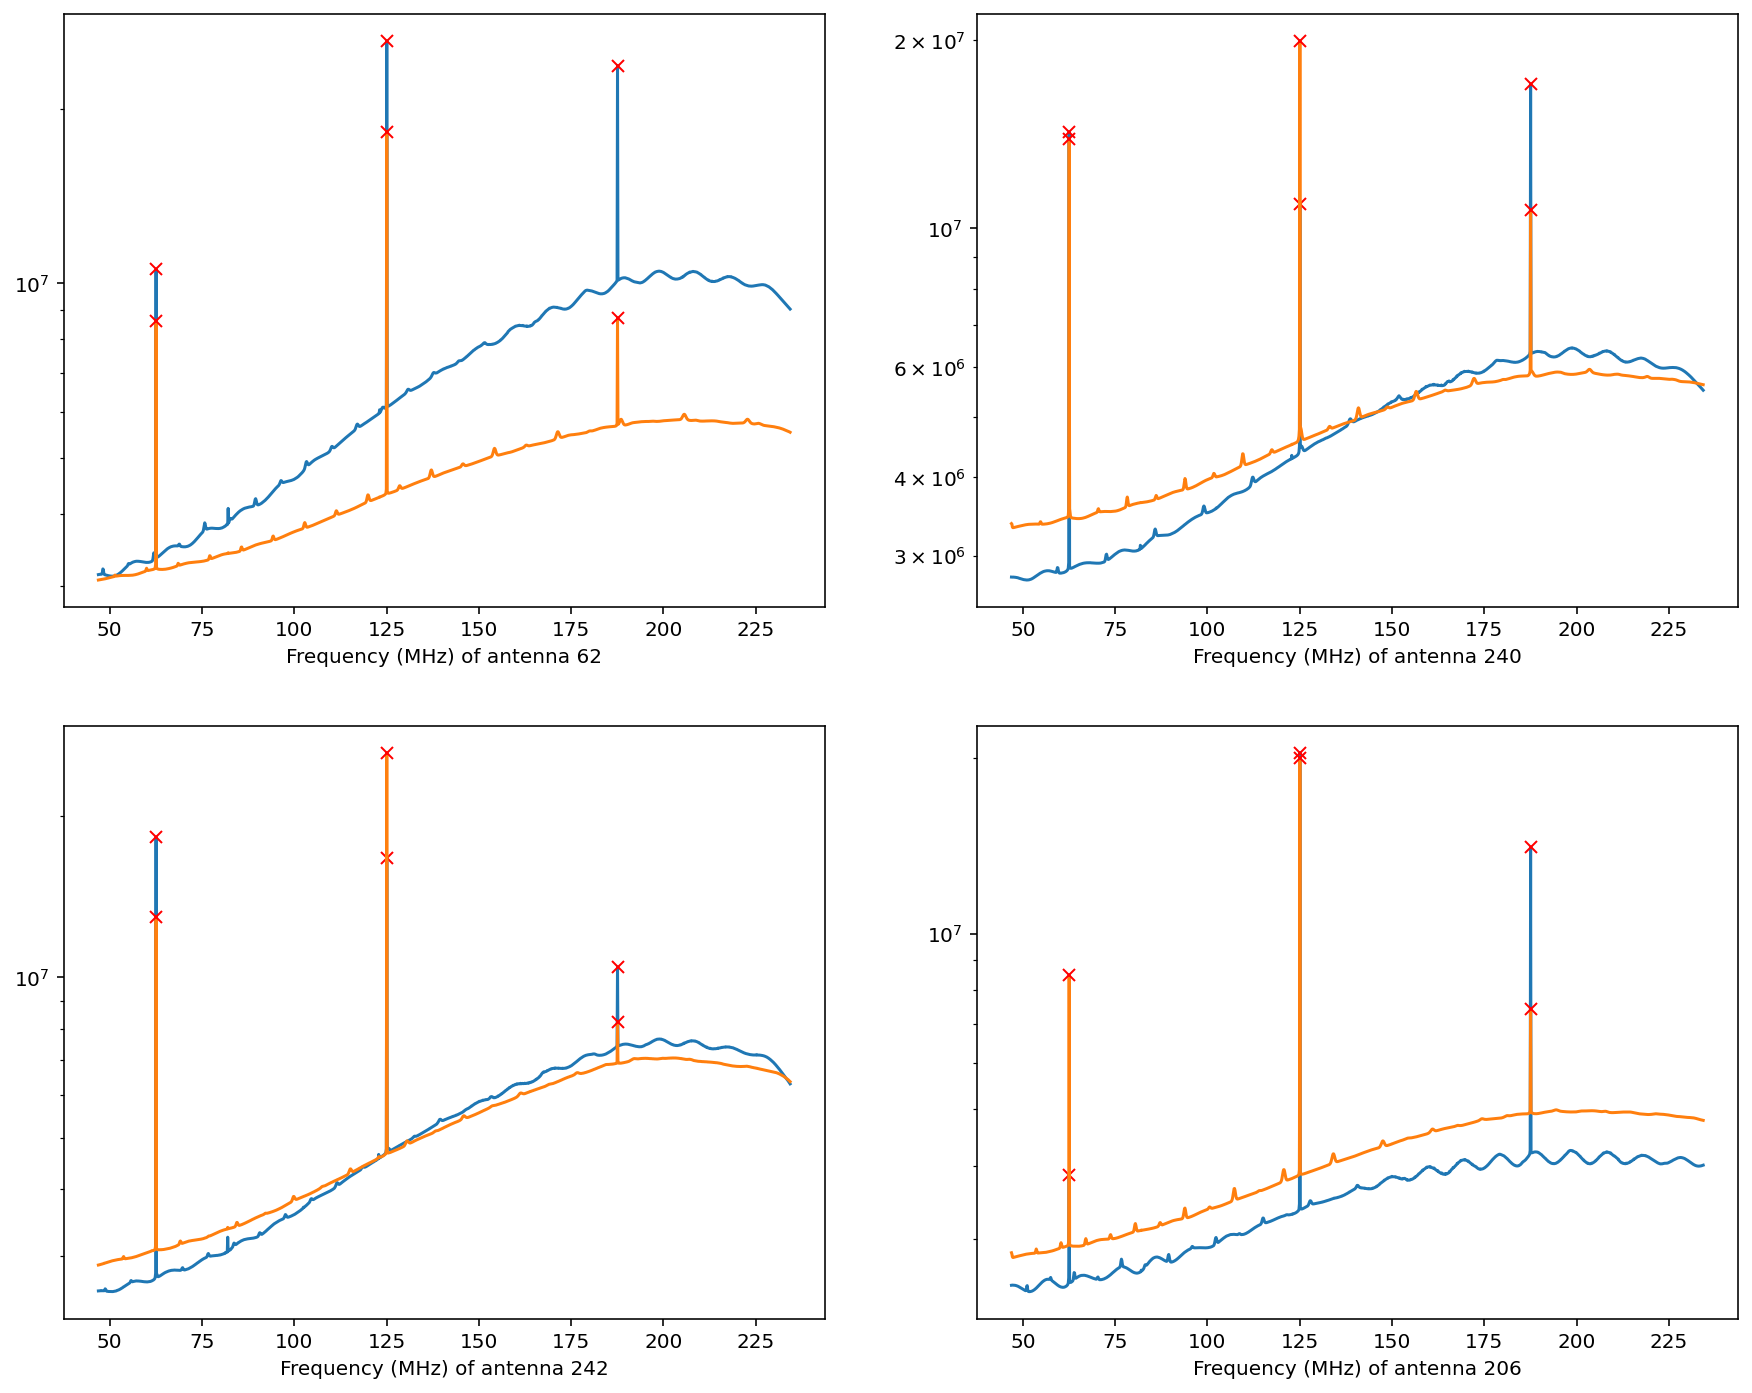

<Figure size 864x864 with 0 Axes>

In [17]:
plot_four_clocks(62, 240, 242, 206)

[ 48.14147949  55.0994873   61.9354248   68.89343262  75.72937012
  82.07702637  89.52331543  96.35925293 103.31726074 110.27526855
 117.11120605]
[ 51.43737793  62.42370605  68.52722168  77.07214355  85.73913574
  94.28405762 102.82897949 111.37390137 119.91882324 128.58581543
 137.1307373 ]
Antenna62 xx and yy
[ 48.14147949  55.0994873   61.9354248   68.89343262  75.72937012
  82.07702637  89.52331543  96.35925293 103.31726074 110.27526855
 117.11120605]
[ 51.43737793  62.42370605  68.52722168  77.07214355  85.73913574
  94.28405762 102.82897949 111.37390137 119.91882324 128.58581543
 137.1307373 ]
Antenna240 xx and yy
[ 47.2869873   56.68640137  62.42370605  67.67272949  72.6776123
  77.5604248   85.86120605  99.0447998  112.35046387 125.4119873
 138.71765137]
[ 54.73327637  62.66784668  70.48034668  78.29284668  86.10534668
  93.91784668 101.73034668 109.54284668 117.47741699 125.16784668
 133.10241699]
Antenna242 xx and yy
[ 48.75183105  55.83190918  62.42370605  69.7479248   76.7

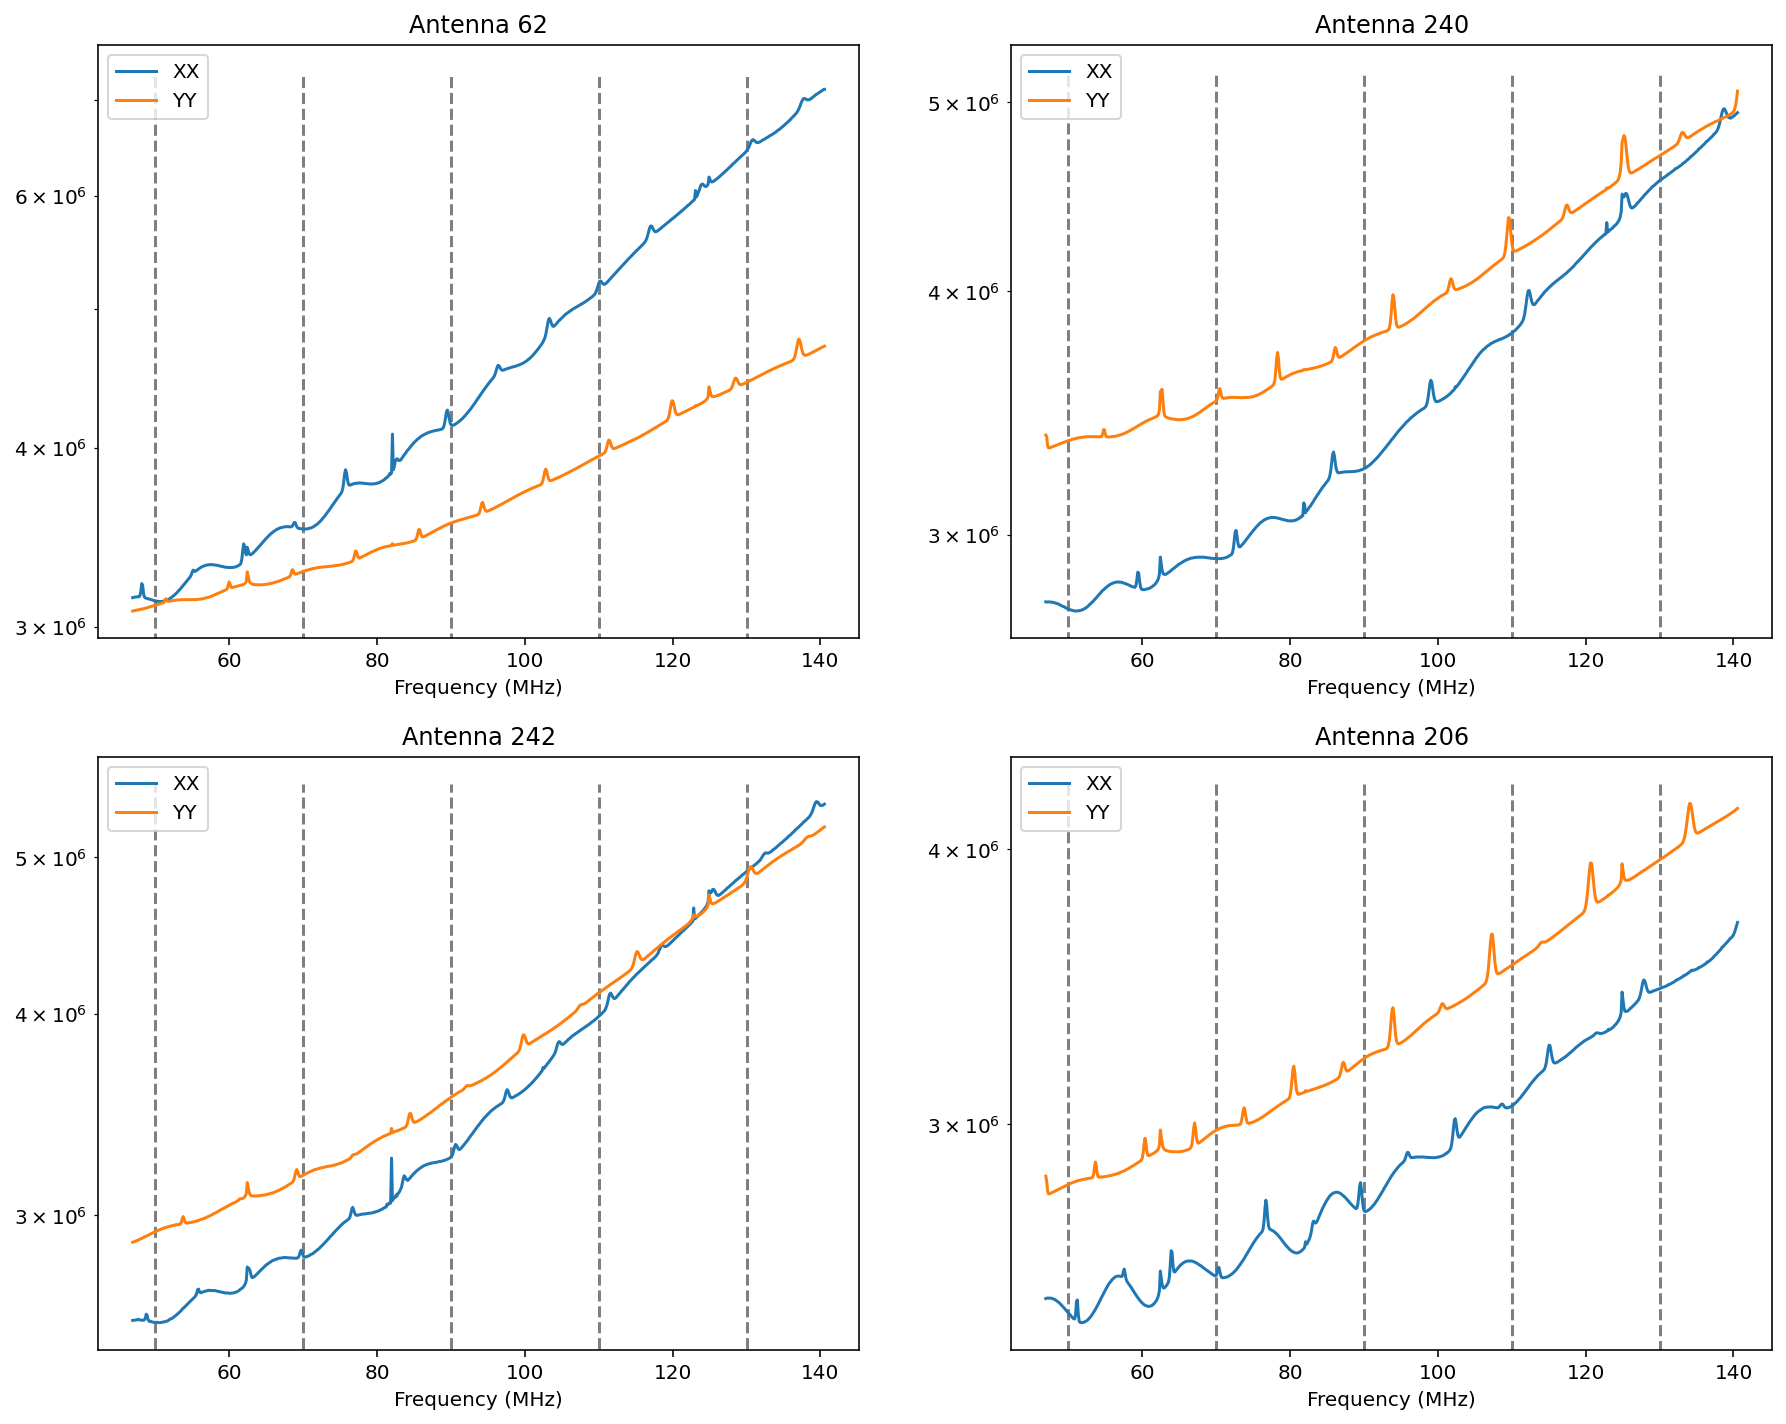

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [20]:
plot_four_noclocks_even(62, 240, 242, 206, 49.973, 20.025, 5)

[ 48.14147949  55.0994873   61.9354248   68.89343262  75.72937012
  82.07702637  89.52331543  96.35925293 103.31726074 110.27526855
 117.11120605]
[ 51.43737793  62.42370605  68.52722168  77.07214355  85.73913574
  94.28405762 102.82897949 111.37390137 119.91882324 128.58581543
 137.1307373 ]
Antenna62 xx and yy
[ 48.14147949  55.0994873   61.9354248   68.89343262  75.72937012
  82.07702637  89.52331543  96.35925293 103.31726074 110.27526855
 117.11120605]
[ 51.43737793  62.42370605  68.52722168  77.07214355  85.73913574
  94.28405762 102.82897949 111.37390137 119.91882324 128.58581543
 137.1307373 ]
Antenna240 xx and yy
[ 47.2869873   56.68640137  62.42370605  67.67272949  72.6776123
  77.5604248   85.86120605  99.0447998  112.35046387 125.4119873
 138.71765137]
[ 54.73327637  62.66784668  70.48034668  78.29284668  86.10534668
  93.91784668 101.73034668 109.54284668 117.47741699 125.16784668
 133.10241699]
Antenna242 xx and yy
[ 48.75183105  55.83190918  62.42370605  69.7479248   76.7

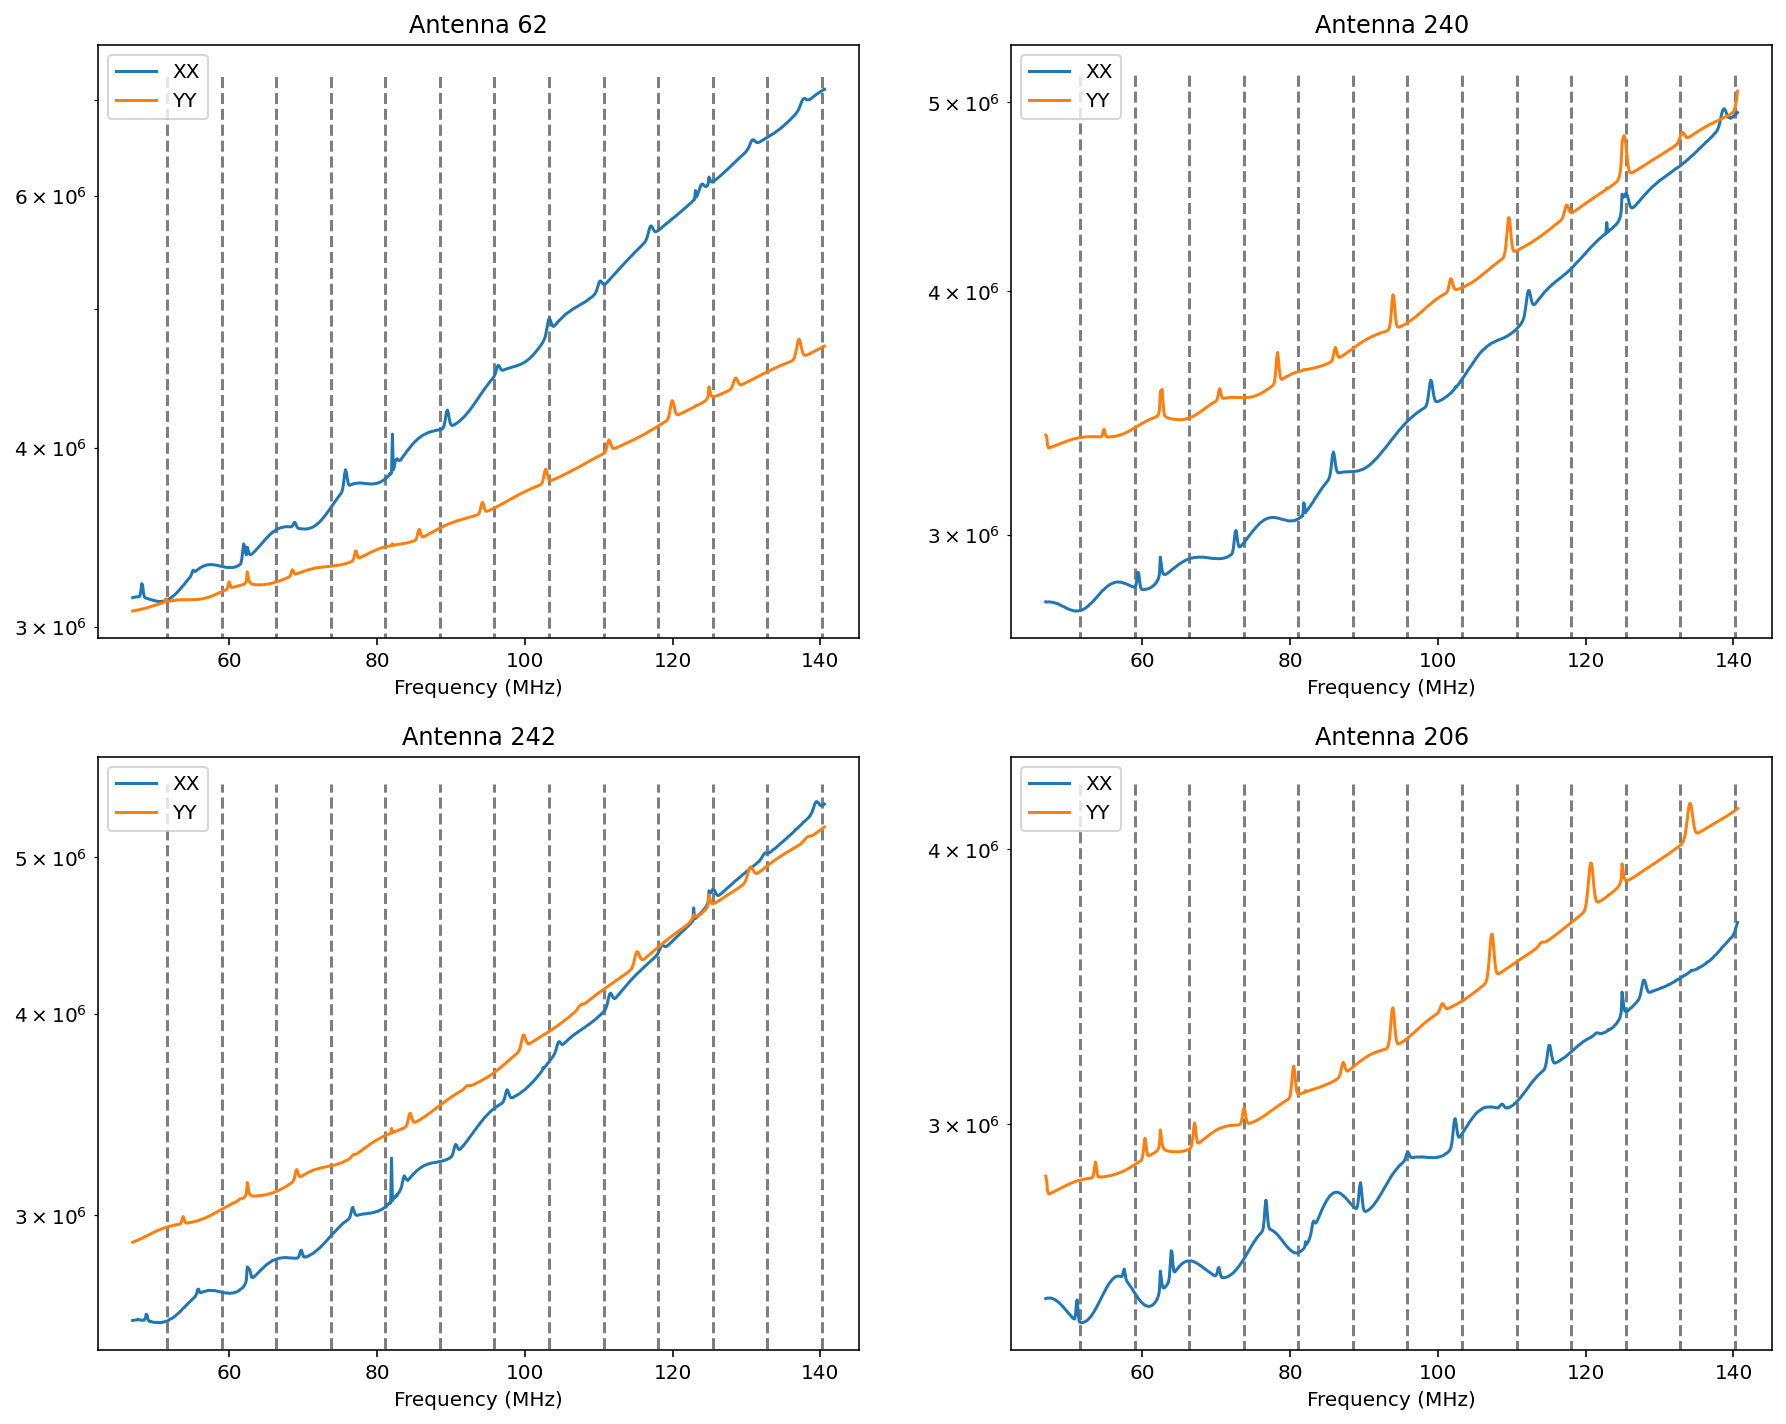

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [21]:
plot_four_noclocks_even(62, 240, 242, 206, 51.559, 7.386, 13)

[ 48.14147949  55.0994873   61.9354248   68.89343262  75.72937012
  82.07702637  89.52331543  96.35925293 103.31726074 110.27526855
 117.11120605]
[ 51.43737793  62.42370605  68.52722168  77.07214355  85.73913574
  94.28405762 102.82897949 111.37390137 119.91882324 128.58581543
 137.1307373 ]
Antenna62 xx and yy
[ 48.14147949  55.0994873   61.9354248   68.89343262  75.72937012
  82.07702637  89.52331543  96.35925293 103.31726074 110.27526855
 117.11120605]
[ 51.43737793  62.42370605  68.52722168  77.07214355  85.73913574
  94.28405762 102.82897949 111.37390137 119.91882324 128.58581543
 137.1307373 ]
Antenna240 xx and yy
[ 47.2869873   56.68640137  62.42370605  67.67272949  72.6776123
  77.5604248   85.86120605  99.0447998  112.35046387 125.4119873
 138.71765137]
[ 54.73327637  62.66784668  70.48034668  78.29284668  86.10534668
  93.91784668 101.73034668 109.54284668 117.47741699 125.16784668
 133.10241699]
Antenna242 xx and yy
[ 48.75183105  55.83190918  62.42370605  69.7479248   76.7

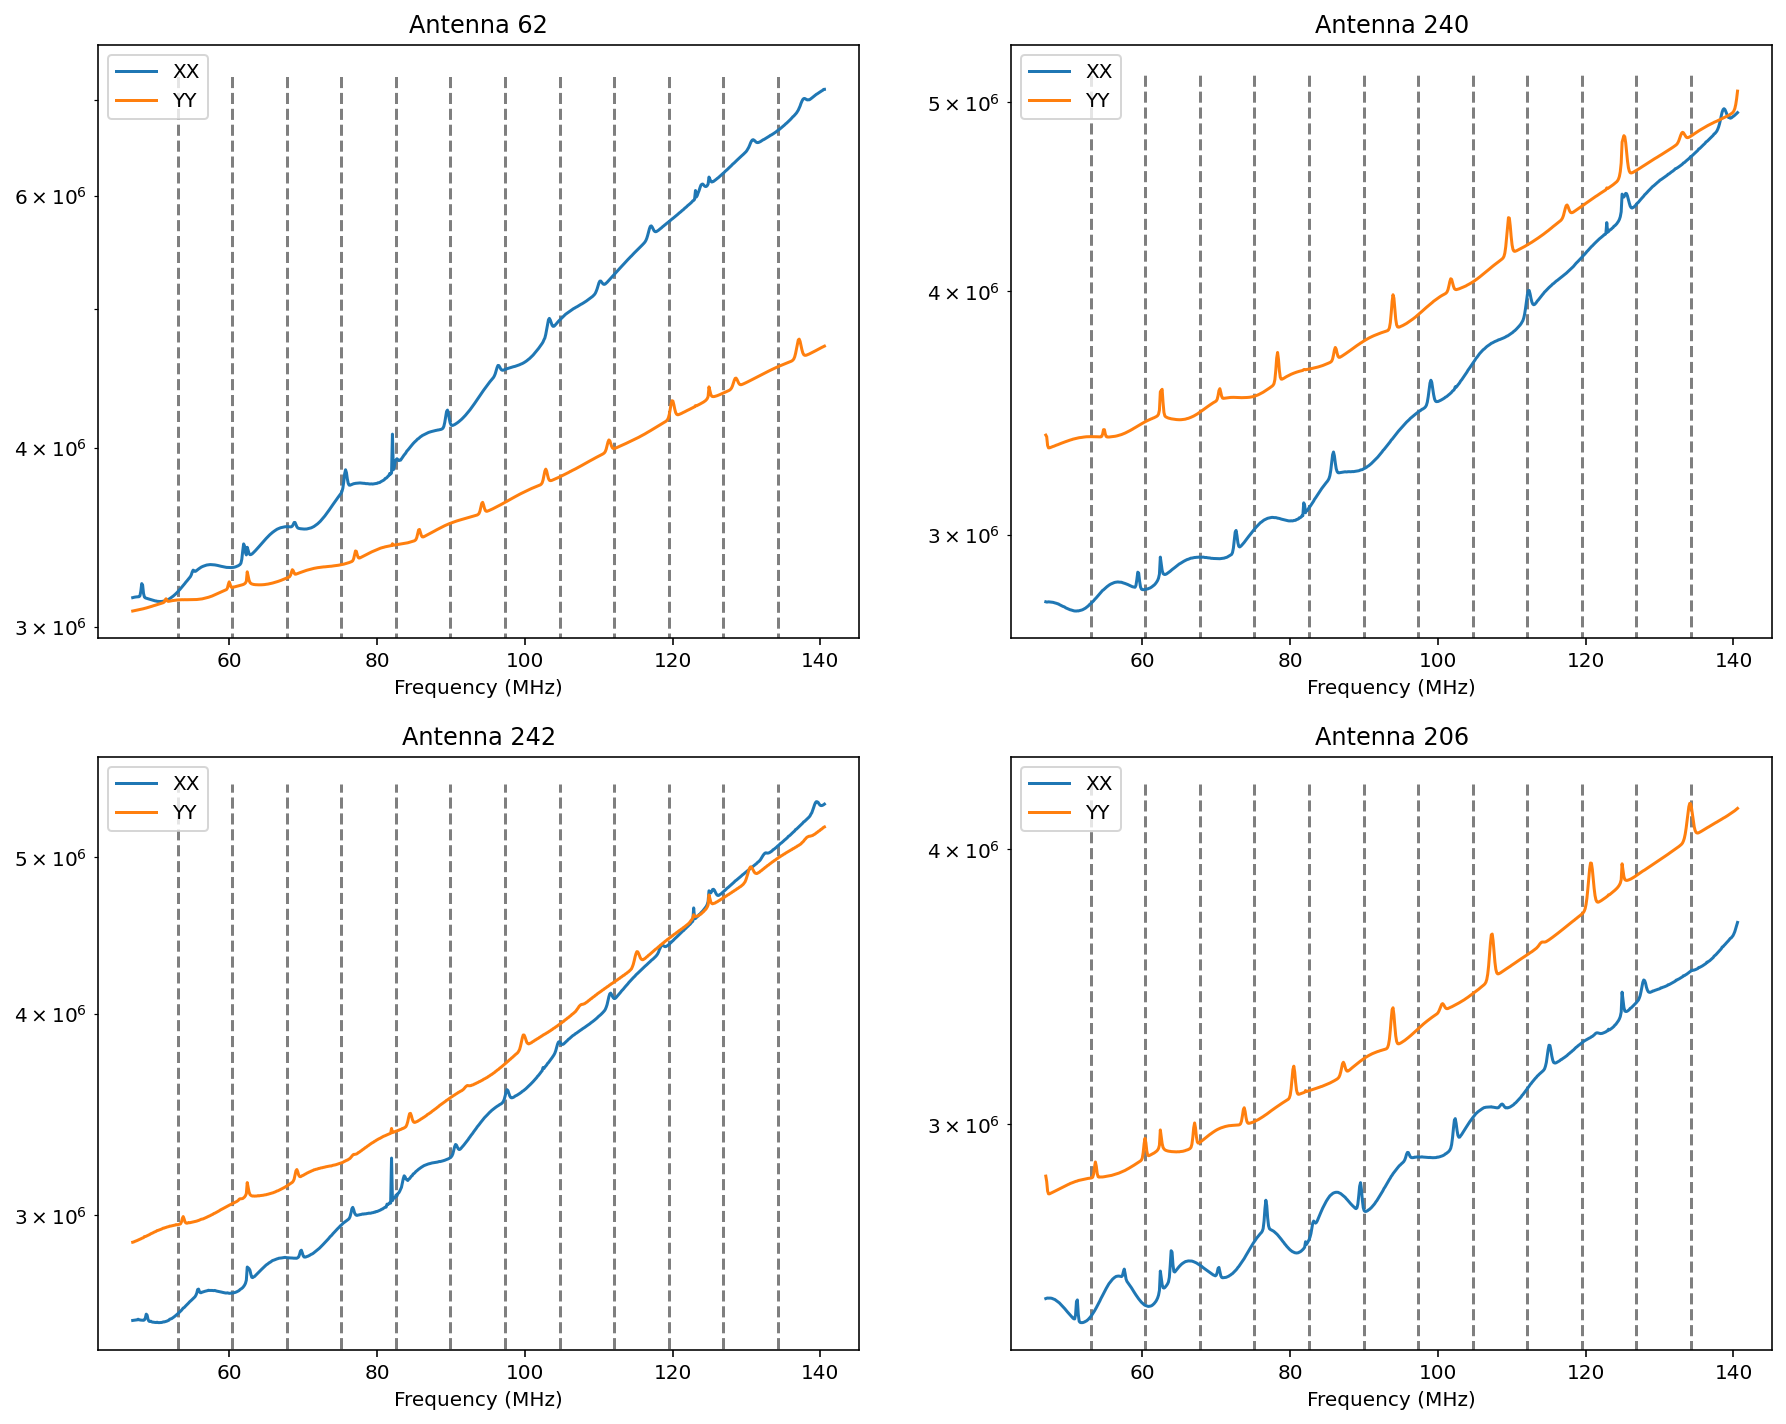

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [22]:
plot_four_noclocks_even(62, 240, 242, 206, 53, 7.386, 12)

[ 48.14147949  55.0994873   61.9354248   68.89343262  75.72937012
  82.07702637  89.52331543  96.35925293 103.31726074 110.27526855
 117.11120605]
[ 51.43737793  62.42370605  68.52722168  77.07214355  85.73913574
  94.28405762 102.82897949 111.37390137 119.91882324 128.58581543
 137.1307373 ]
Antenna62 xx and yy
[ 48.14147949  55.0994873   61.9354248   68.89343262  75.72937012
  82.07702637  89.52331543  96.35925293 103.31726074 110.27526855
 117.11120605]
[ 51.43737793  62.42370605  68.52722168  77.07214355  85.73913574
  94.28405762 102.82897949 111.37390137 119.91882324 128.58581543
 137.1307373 ]
Antenna68 xx and yy
[ 49.2401123   63.27819824  81.95495605  91.35437012 105.39245605
 119.5526123  124.92370605 133.59069824]
[ 49.97253418  56.32019043  63.40026855  69.99206543  77.43835449
  84.51843262  90.01159668  98.55651855 105.63659668 112.7166748
 119.67468262]
Antenna207 xx and yy
[ 49.97253418  56.68640137  62.42370605  69.99206543  76.33972168
  81.83288574  87.3260498   94.6

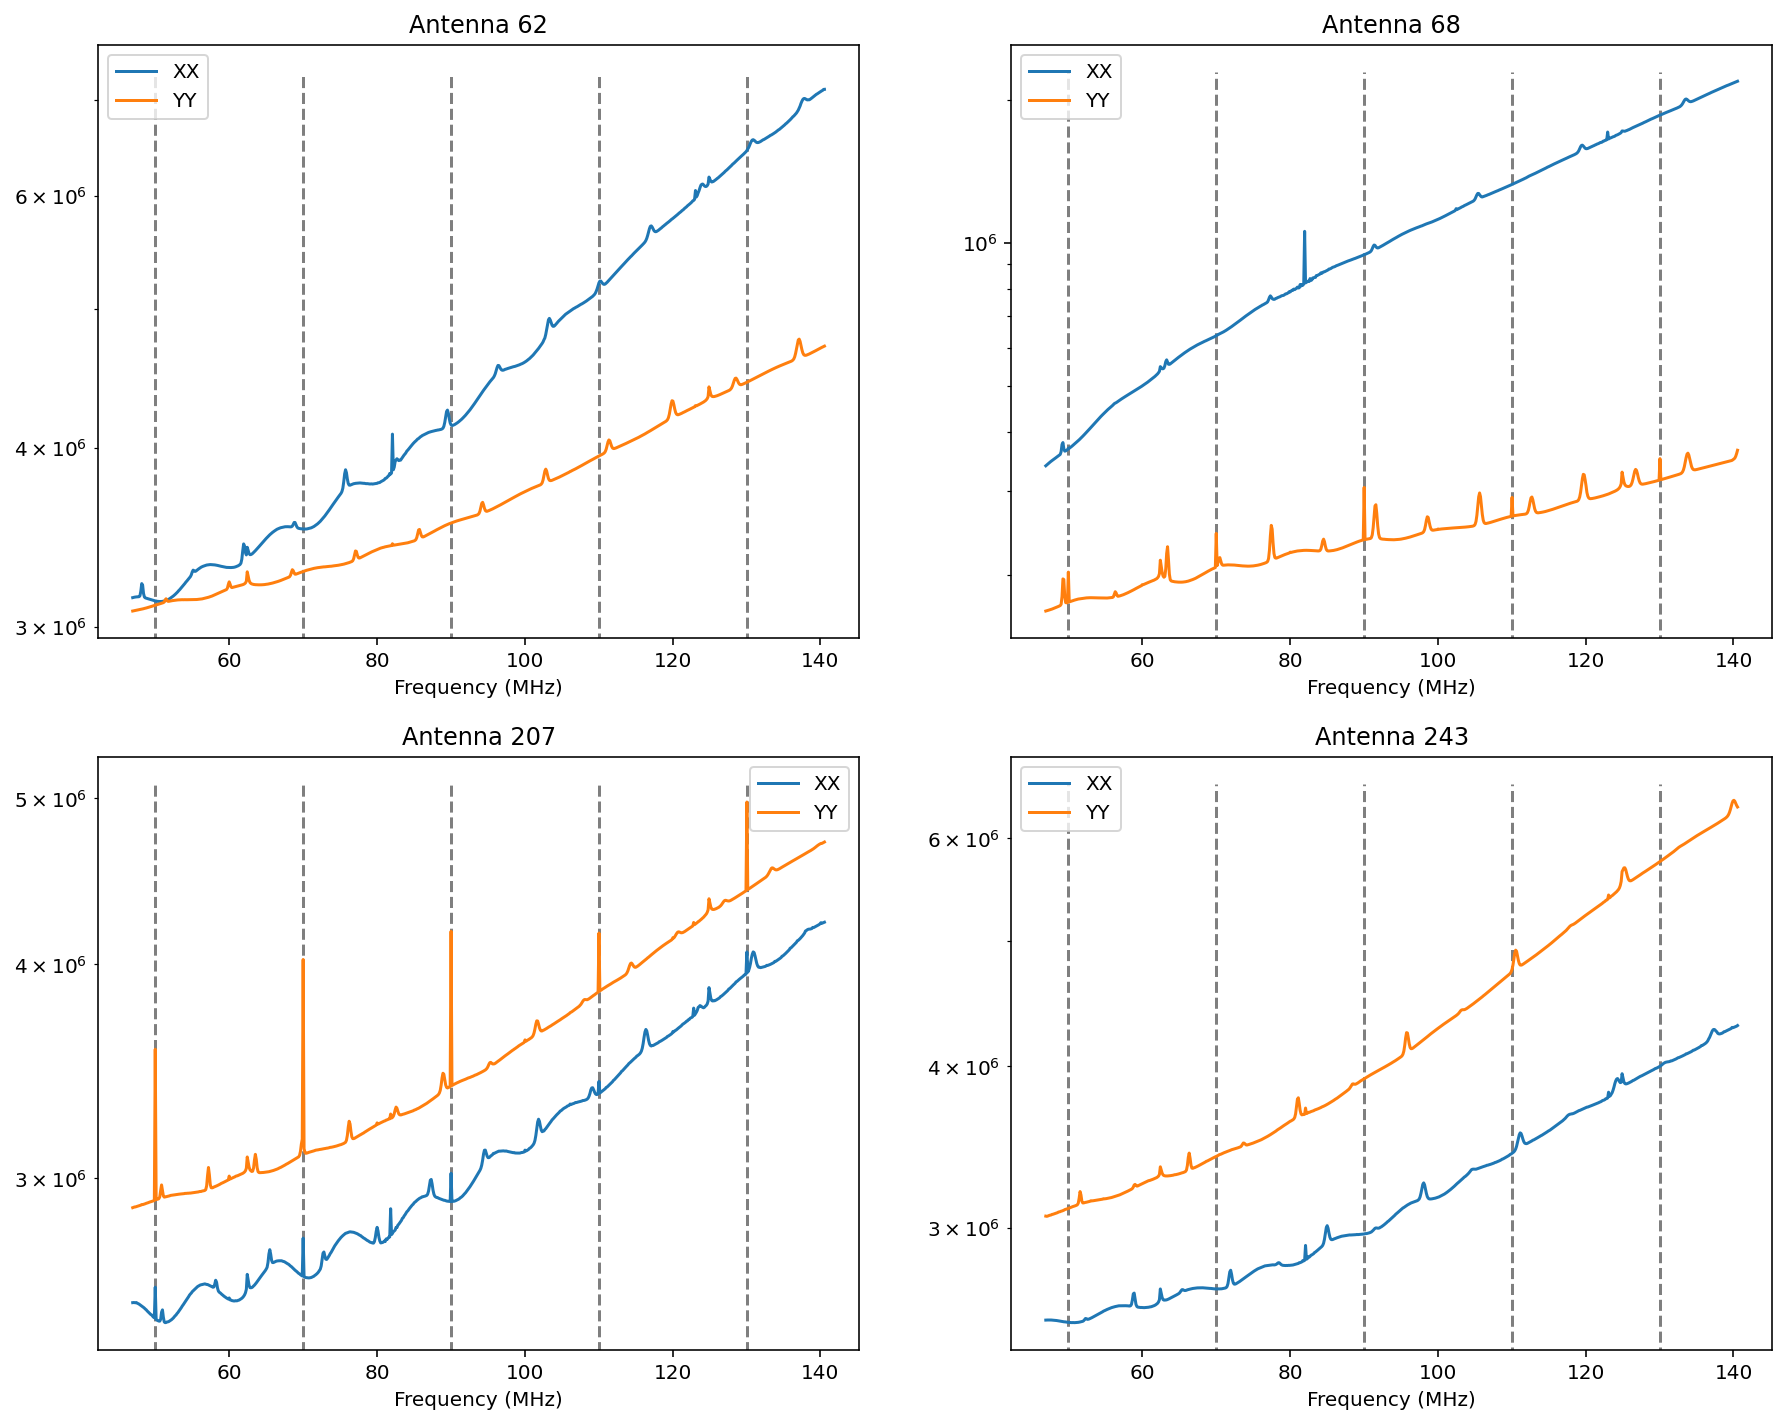

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [23]:
plot_four_noclocks_even(62, 68, 207, 243, 49.973, 20.025, 5)

[ 48.14147949  55.0994873   61.9354248   68.89343262  75.72937012
  82.07702637  89.52331543  96.35925293 103.31726074 110.27526855
 117.11120605]
[ 51.43737793  62.42370605  68.52722168  77.07214355  85.73913574
  94.28405762 102.82897949 111.37390137 119.91882324 128.58581543
 137.1307373 ]
Antenna62 xx and yy
[ 48.14147949  55.0994873   61.9354248   68.89343262  75.72937012
  82.07702637  89.52331543  96.35925293 103.31726074 110.27526855
 117.11120605]
[ 51.43737793  62.42370605  68.52722168  77.07214355  85.73913574
  94.28405762 102.82897949 111.37390137 119.91882324 128.58581543
 137.1307373 ]
Antenna240 xx and yy
[ 47.2869873   56.68640137  62.42370605  67.67272949  72.6776123
  77.5604248   85.86120605  99.0447998  112.35046387 125.4119873
 138.71765137]
[ 54.73327637  62.66784668  70.48034668  78.29284668  86.10534668
  93.91784668 101.73034668 109.54284668 117.47741699 125.16784668
 133.10241699]
Antenna242 xx and yy
[ 48.75183105  55.83190918  62.42370605  69.7479248   76.7

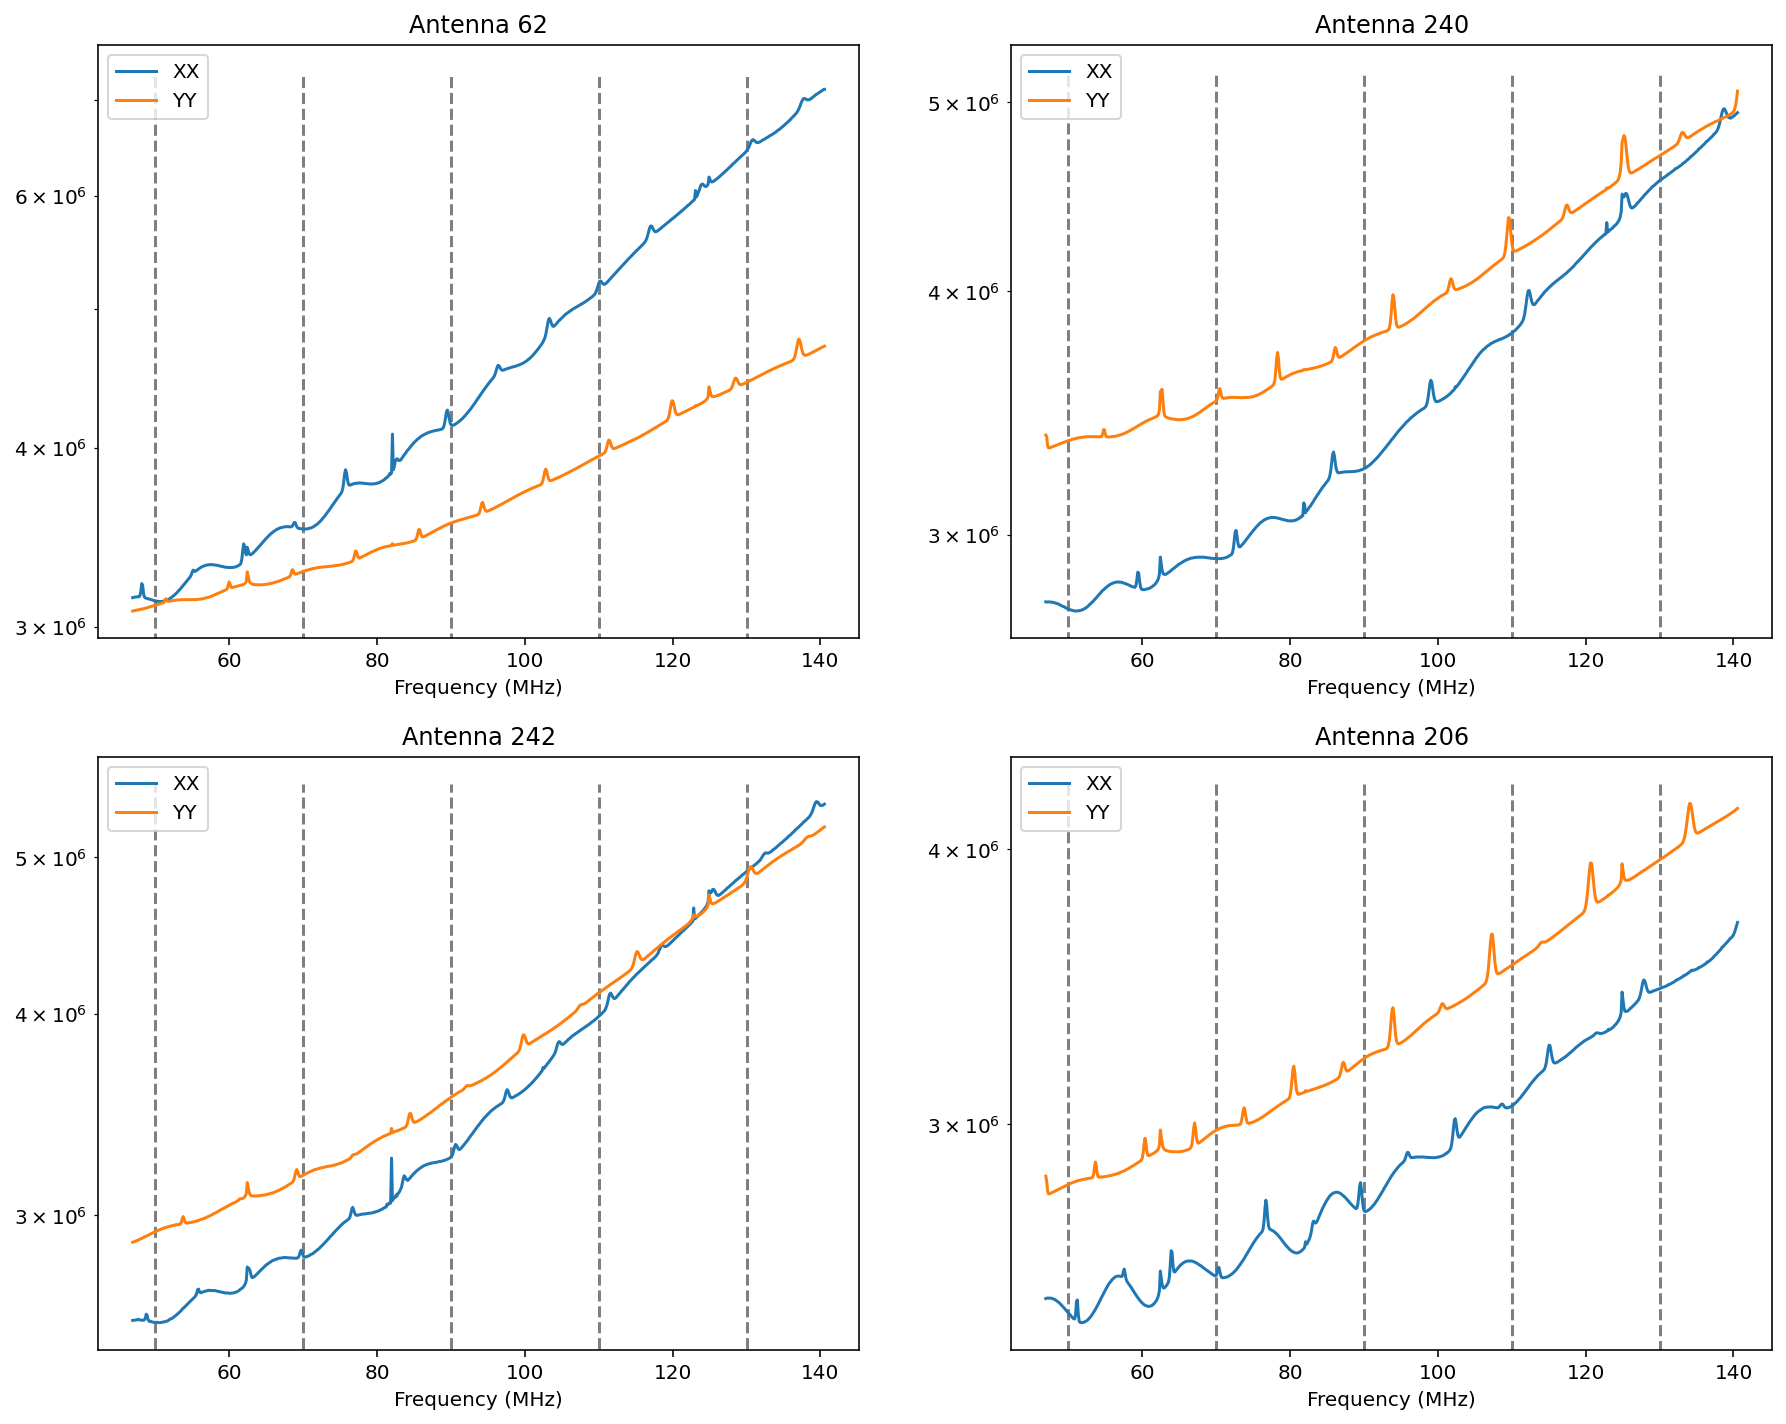

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [26]:
plot_four_noclocks_even(62, 240, 242, 206, 49.973, 20.025, 5)

Text(0.5, 0, 'Frequency (MHz)')

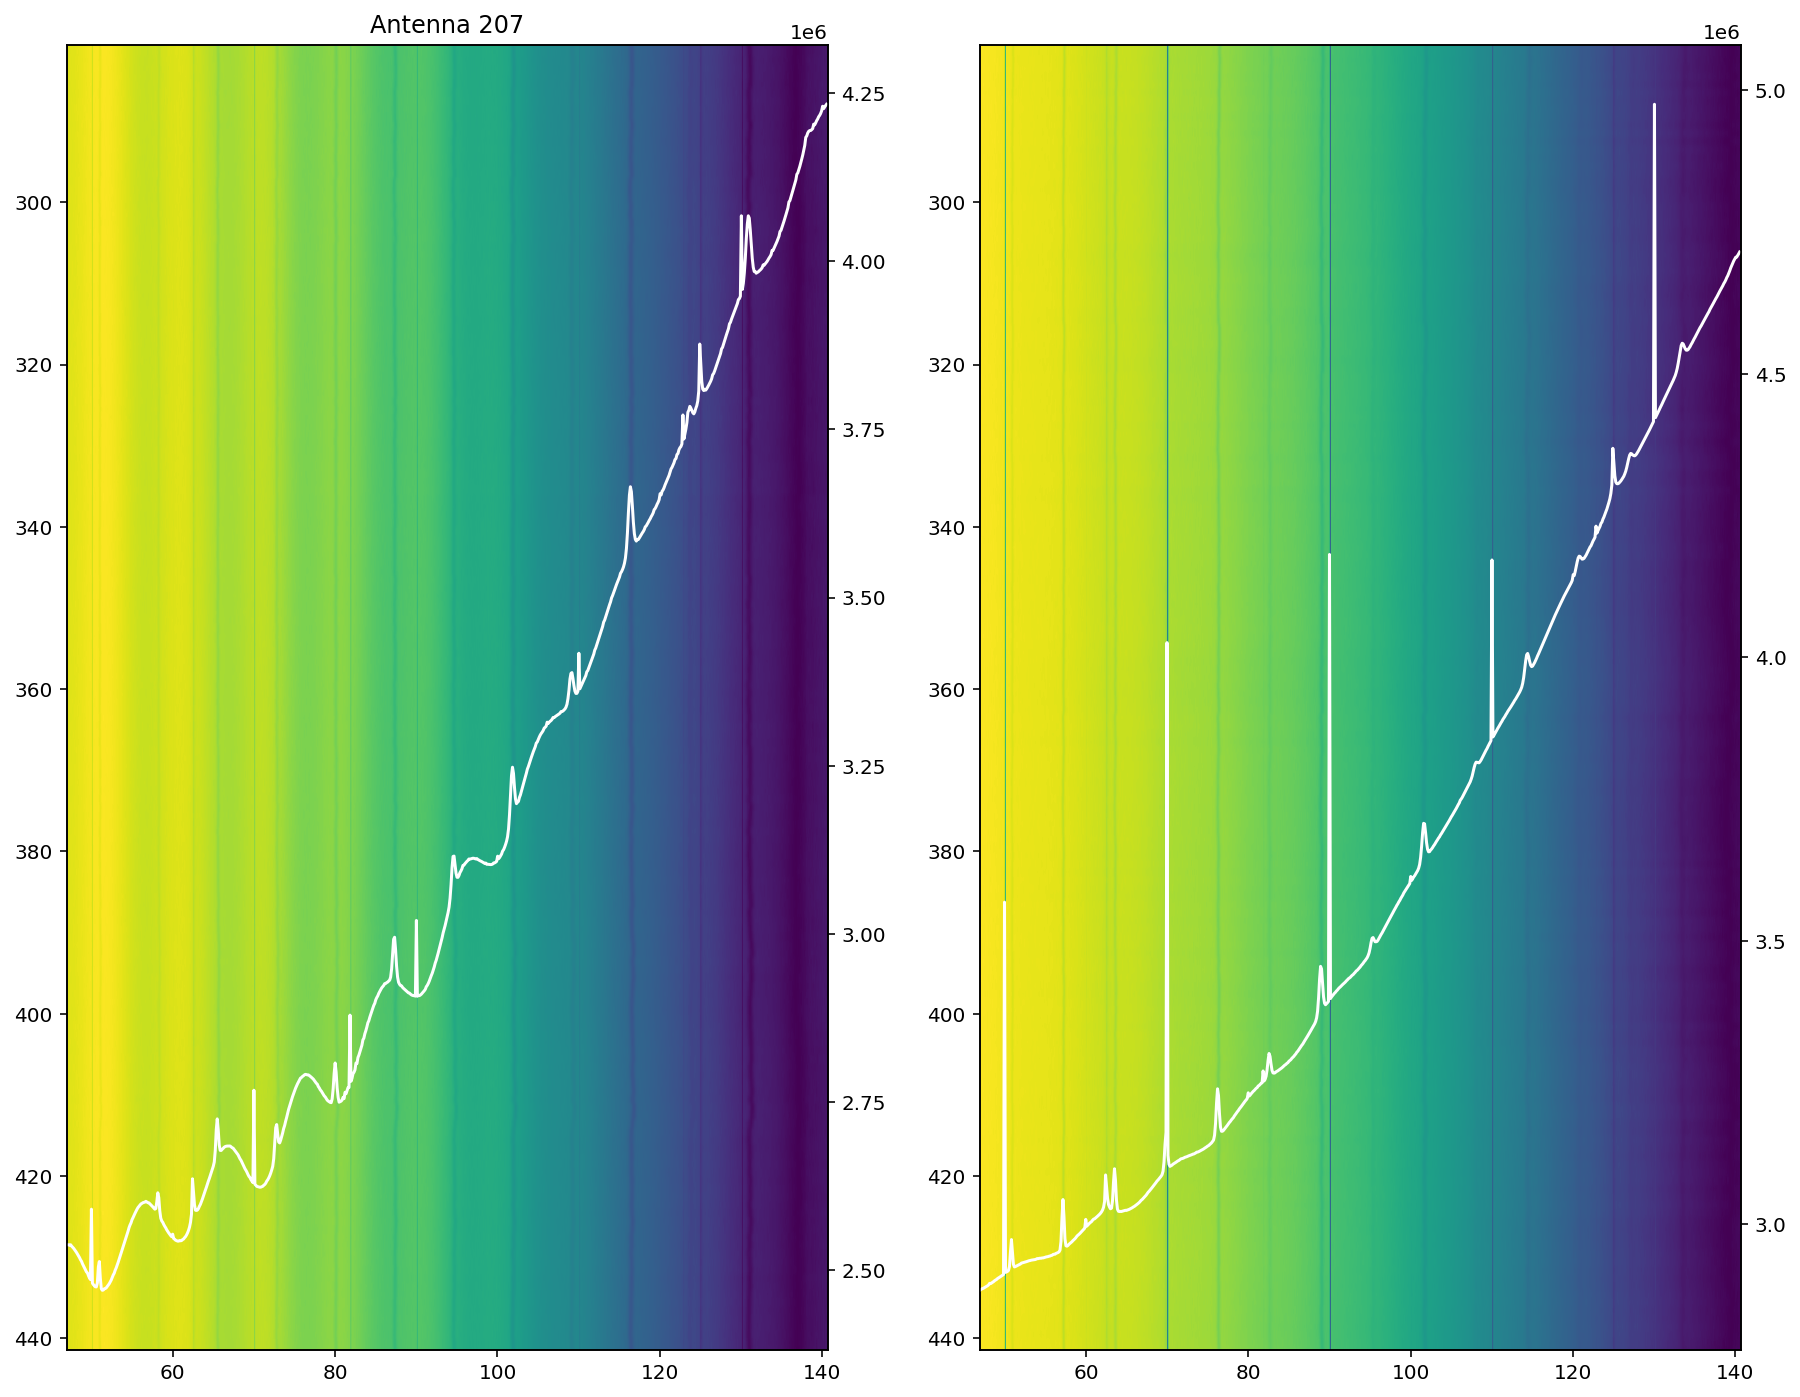

In [63]:
data1 = uvd.get_data(207,207,'XX')
data2 = uvd.get_data(207,207,'YY')
freq = uvd.freq_array[0]*1e-6 #converted to MegaHz

data1_average = np.average(data1)
data2_average = np.average(data2)

mean_sub1 = data1 - data1_average
mean_sub1[:,128] = (mean_sub1[:,127] + mean_sub1[:,129])/2
mean_sub1[:,1152] = (mean_sub1[:,1151] + mean_sub1[:,1153])/2
mean_sub1[:,640] = (mean_sub1[:,639] + mean_sub1[:,641])/2

mean_sub2 = data2 - data2_average
mean_sub2[:,128] = (mean_sub2[:,127] + mean_sub2[:,129])/2
mean_sub2[:,1152] = (mean_sub2[:,1151] + mean_sub2[:,1153])/2
mean_sub2[:,640] = (mean_sub2[:,639] + mean_sub2[:,641])/2

fig, ax = plt.subplots(1 , 2, figsize = (15,12))

ax[0].imshow(np.abs(mean_sub1[:,0:768]), extent = (freq[0], freq[768], uvd.Ntimes, 0))
axtwin = ax[0].twinx()
ax[1].imshow(np.abs(mean_sub2[:,0:768]), extent = (freq[0], freq[768], uvd.Ntimes, 0))
axtwin2 = ax[1].twinx()

data1_avg = np.average(data1, axis=0)
data1_avg[128] = (data1_avg[127] + data1_avg[129])/2
data1_avg[1152] = (data1_avg[1151] + data1_avg[1153])/2
data1_avg[640] = (data1_avg[639] + data1_avg[641])/2
data2_avg = np.average(data2, axis=0)
data2_avg[128] = (data2_avg[127] + data2_avg[129])/2
data2_avg[1152] = (data2_avg[1151] + data2_avg[1153])/2
data2_avg[640] = (data2_avg[639] + data2_avg[641])/2
peaks1, _ = find_peaks(data1_avg[0:768], distance=40)
peaks2, _ = find_peaks(data2_avg[0:768], distance=40)
axtwin.plot(freq[0:768],data1_avg[0:768], label = 'XX', color = 'white')
#ax[0,0].plot(freq[peaks1],data1_avg[peaks1],"xr")
axtwin2.plot(freq[0:768],data2_avg[0:768], label = 'YY', color = 'white')
#ax[0,0].plot(freq[peaks2],data2_avg[peaks2],"xr")


axmin, axmax = axtwin.get_ylim()

lines = np.arange(0,5,1)
number = 0
    
# for i in lines:
#     axtwin.vlines(49.973+20.025*number, ymin = axmin, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)
#     number = (number + 1)



axtwin.set_title(f'Antenna {207}')
#ax[0].set_yscale('log')
axtwin.set_xlabel(f'Frequency (MHz)')

Text(0.5, 0, 'Frequency (MHz)')

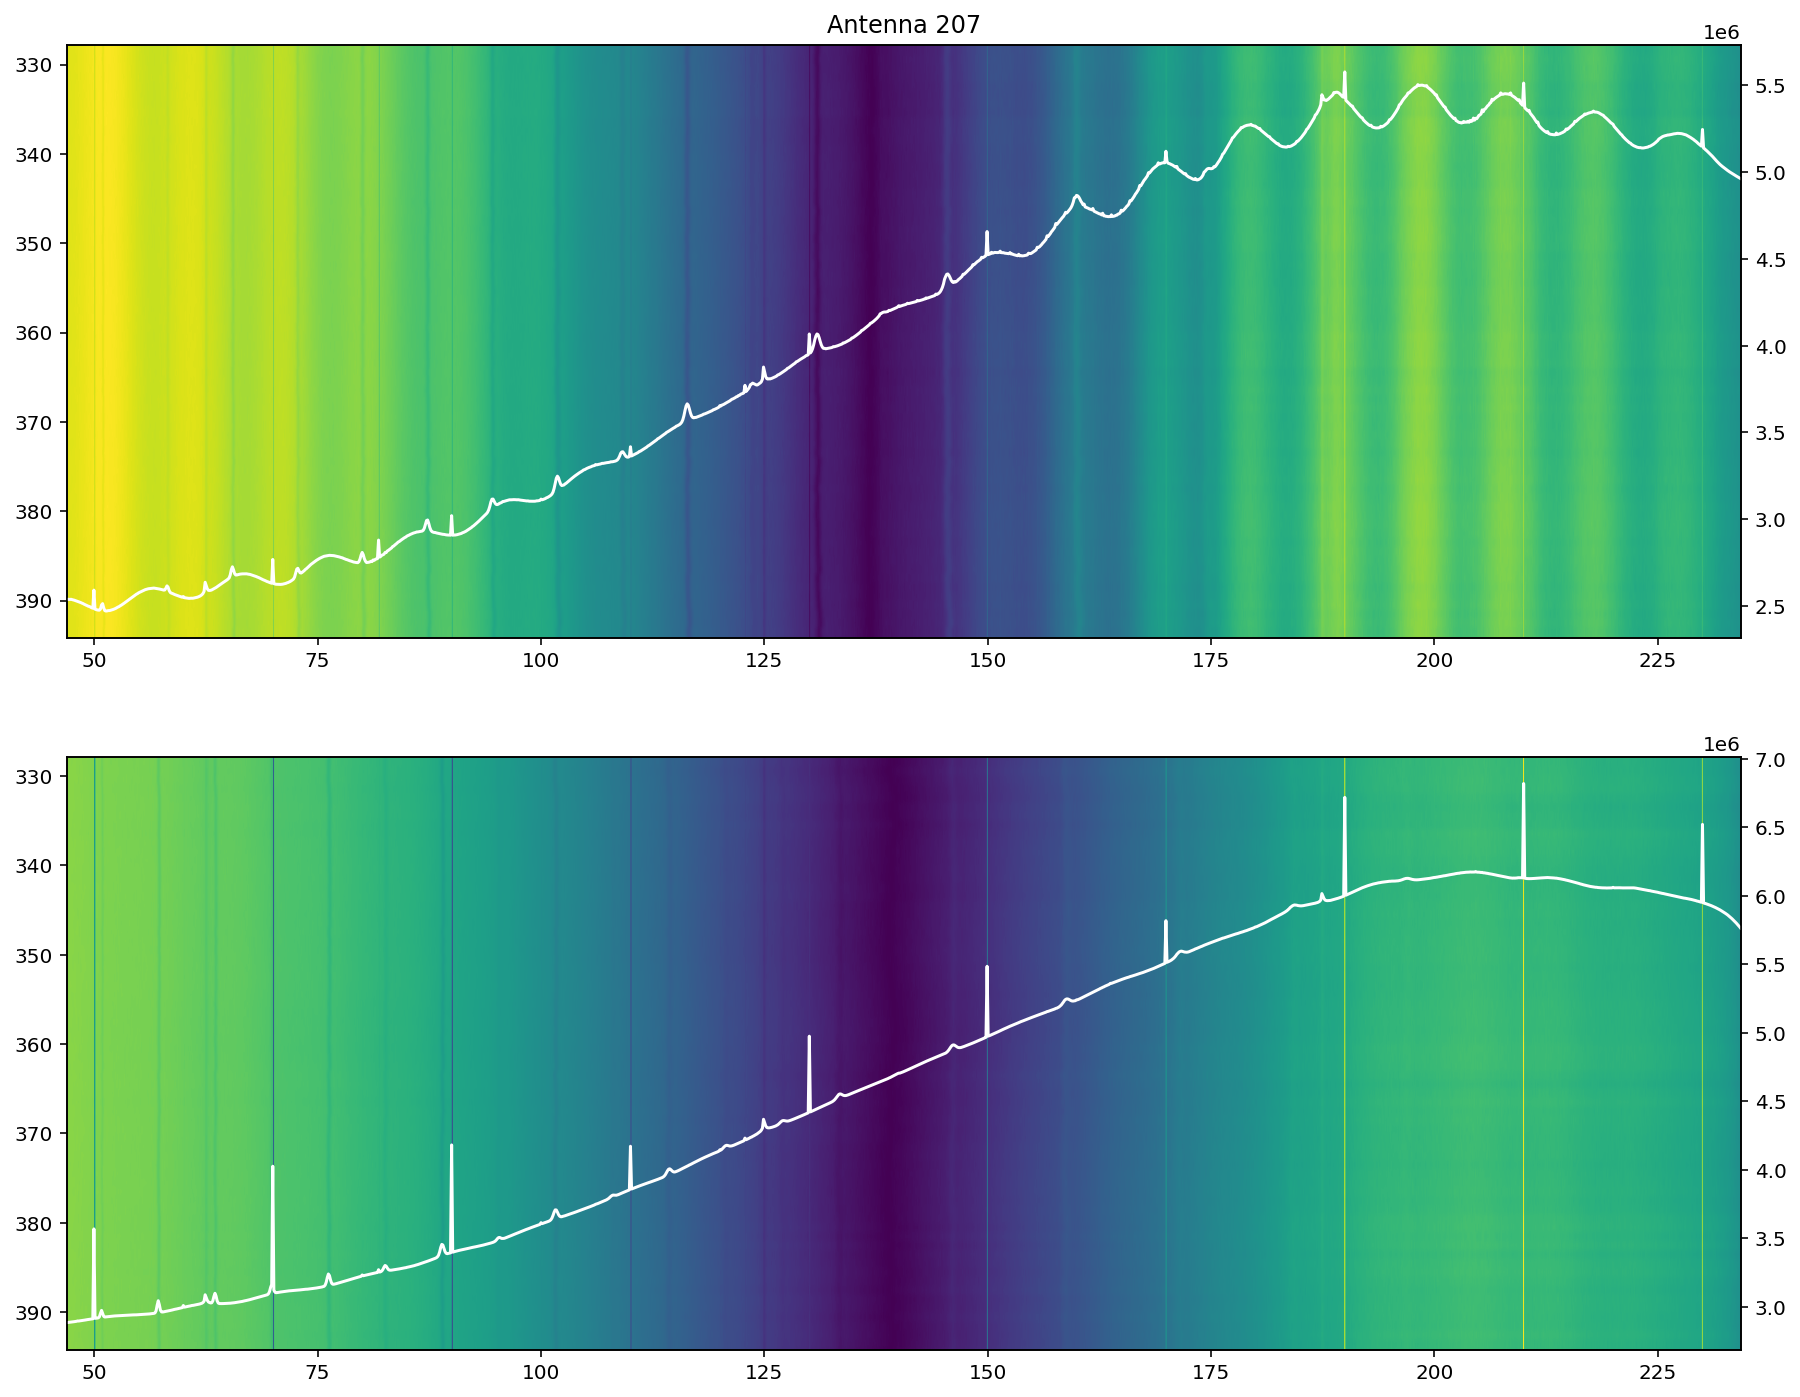

In [69]:
data1 = uvd.get_data(207,207,'XX')
data2 = uvd.get_data(207,207,'YY')
freq = uvd.freq_array[0]*1e-6 #converted to MegaHz

data1_average = np.average(data1)
data2_average = np.average(data2)

mean_sub1 = data1 - data1_average
mean_sub1[:,128] = (mean_sub1[:,127] + mean_sub1[:,129])/2
mean_sub1[:,1152] = (mean_sub1[:,1151] + mean_sub1[:,1153])/2
mean_sub1[:,640] = (mean_sub1[:,639] + mean_sub1[:,641])/2

mean_sub2 = data2 - data2_average
mean_sub2[:,128] = (mean_sub2[:,127] + mean_sub2[:,129])/2
mean_sub2[:,1152] = (mean_sub2[:,1151] + mean_sub2[:,1153])/2
mean_sub2[:,640] = (mean_sub2[:,639] + mean_sub2[:,641])/2

fig, ax = plt.subplots(2 , 1, figsize = (15,12))

ax[0].imshow(np.abs(mean_sub1), extent = (freq[0], freq[-1], uvd.Ntimes, 0))
axtwin = ax[0].twinx()
ax[1].imshow(np.abs(mean_sub2), extent = (freq[0], freq[-1], uvd.Ntimes, 0))
axtwin2 = ax[1].twinx()

data1_avg = np.average(data1, axis=0)
data1_avg[128] = (data1_avg[127] + data1_avg[129])/2
data1_avg[1152] = (data1_avg[1151] + data1_avg[1153])/2
data1_avg[640] = (data1_avg[639] + data1_avg[641])/2
data2_avg = np.average(data2, axis=0)
data2_avg[128] = (data2_avg[127] + data2_avg[129])/2
data2_avg[1152] = (data2_avg[1151] + data2_avg[1153])/2
data2_avg[640] = (data2_avg[639] + data2_avg[641])/2
peaks1, _ = find_peaks(data1_avg[0:768], distance=40)
peaks2, _ = find_peaks(data2_avg[0:768], distance=40)
axtwin.plot(freq,data1_avg, label = 'XX', color = 'white')
#ax[0,0].plot(freq[peaks1],data1_avg[peaks1],"xr")
axtwin2.plot(freq,data2_avg, label = 'YY', color = 'white')
#ax[0,0].plot(freq[peaks2],data2_avg[peaks2],"xr")


axmin, axmax = axtwin.get_ylim()

lines = np.arange(0,5,1)
number = 0
    
# for i in lines:
#     axtwin.vlines(49.973+20.025*number, ymin = axmin, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)
#     number = (number + 1)



axtwin.set_title(f'Antenna {207}')
#ax[0].set_yscale('log')
axtwin.set_xlabel(f'Frequency (MHz)')